In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
from sklearn.svm import SVR

import pickle
warnings.filterwarnings('ignore')

## Functions

In [2]:
def predict_evaluate(pred, true, graphName = 'Energy Usage Prediction', showplots=False):
    
    diff = [abs(pred[i]-true[i]) for i in range(len(pred))]
    

    
    mape = mean_absolute_percentage_error(true, pred)
    mae = mean_absolute_error(true, pred)
    maxae = max(diff)
    mse = mean_squared_error(true, pred)
    df = pd.DataFrame({'Actual': true,
                       'Forecasted': pred})

    wape = (df.Actual - df.Forecasted).abs().sum() / df.Actual.sum()
    
    if showplots:
        resultingPlot = plt.figure(figsize=(25,10))
        plt.plot(true, color='red', label='Original Usage')
        plt.plot(pred, color='blue', label='Predicted Usage')
        plt.plot(diff, color='green', label='Error')
        plt.title(graphName)
        plt.ylabel('kW')
        plt.legend()
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
        print("wape: ", wape)
    
    return {"name":graphName, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=73, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=37))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=16,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    loss_per_epoch = history.history['loss']
    
    if showplot:
        plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [4]:
directory = "../../datsets/LCL_Data_Transformed_final/train"
allHouses = sorted(os.listdir(directory))

testNumber = 5

testUsers = sample(allHouses, testNumber)
testUsers = ["MAC000205.csv", "MAC002086.csv", "MAC000387.csv", "MAC000276.csv", "MAC001251.csv"]
featuresNames = ['use', 'hour', 'weekday']
targetName = ['use']
past_window = 24

## Test specific model SVM

Testing with  MAC000205.csv


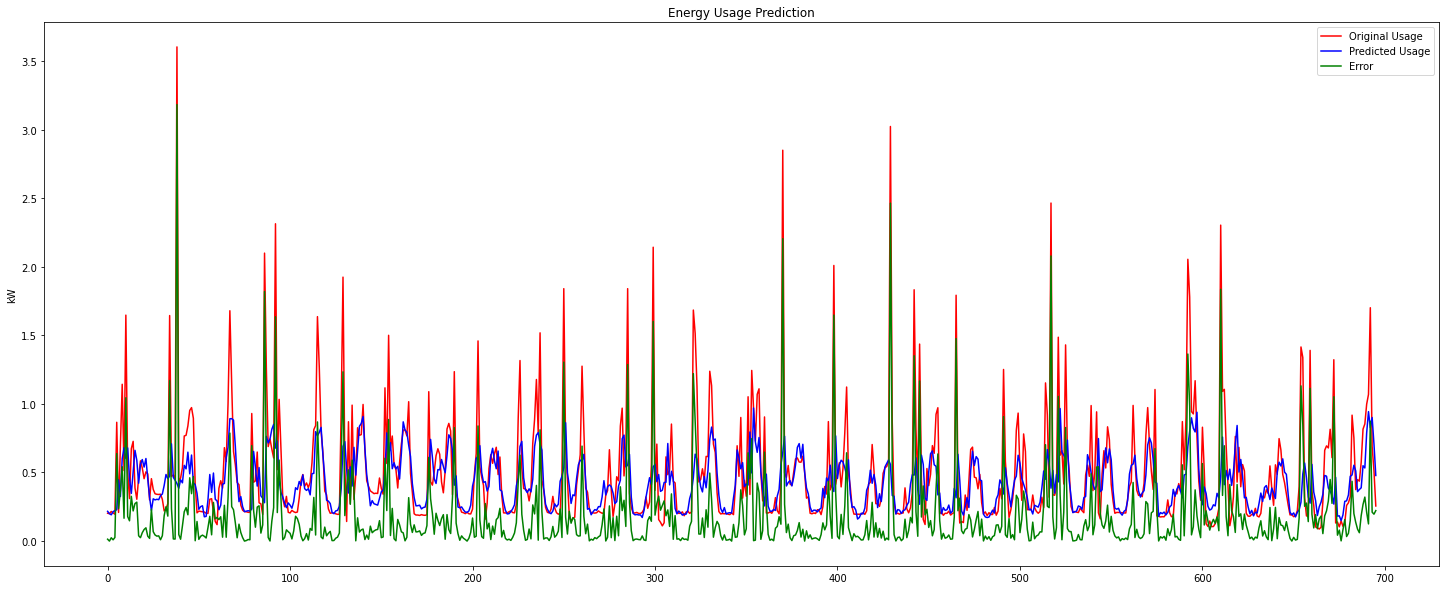

Mean Absolute Percentage Error:  0.35958025930638593
Mean Absolute Error:  0.1901847582851189
Max Absolute Error:  3.181904909794564
Mean Squared Error:  0.13615916224179186
wape:  0.3816680653904167
Testing with  MAC002086.csv


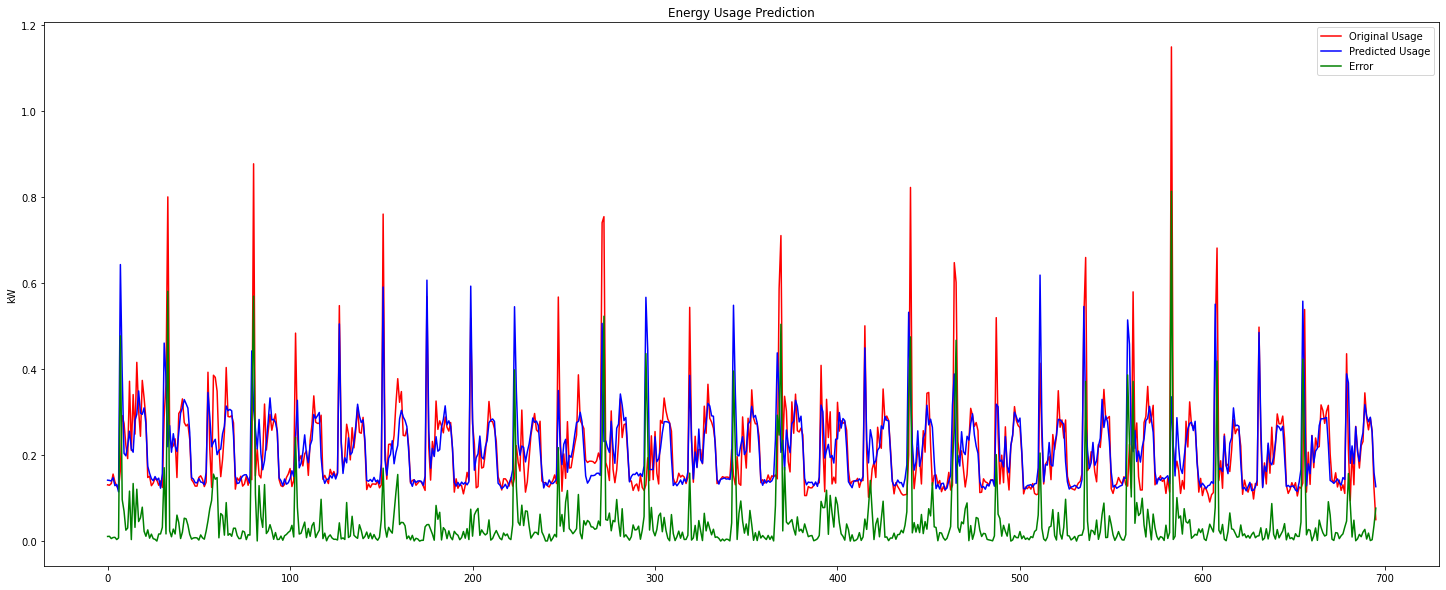

Mean Absolute Percentage Error:  0.20263946715199804
Mean Absolute Error:  0.044242573192527467
Max Absolute Error:  0.8142451621418738
Mean Squared Error:  0.008518437775372546
wape:  0.20803155615456773
Testing with  MAC000387.csv


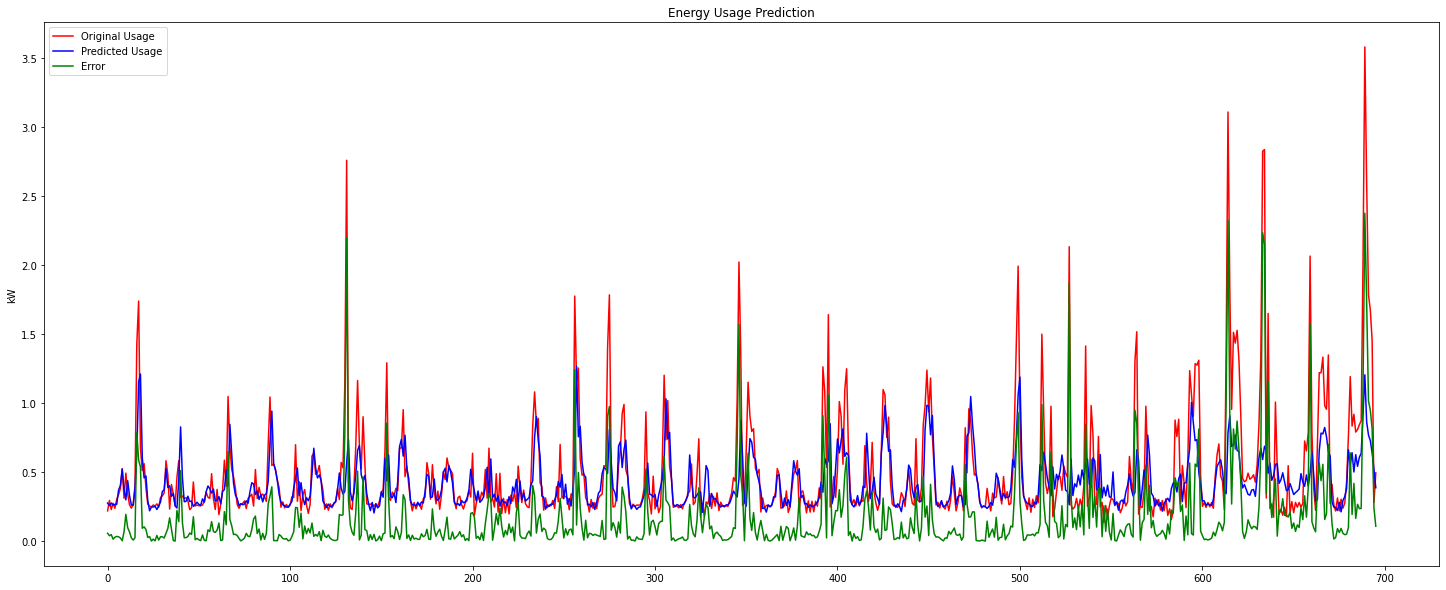

Mean Absolute Percentage Error:  0.30325771091451953
Mean Absolute Error:  0.17407464199192632
Max Absolute Error:  2.3780504158923286
Mean Squared Error:  0.11689040379710756
wape:  0.3529729057011577
Testing with  MAC000276.csv


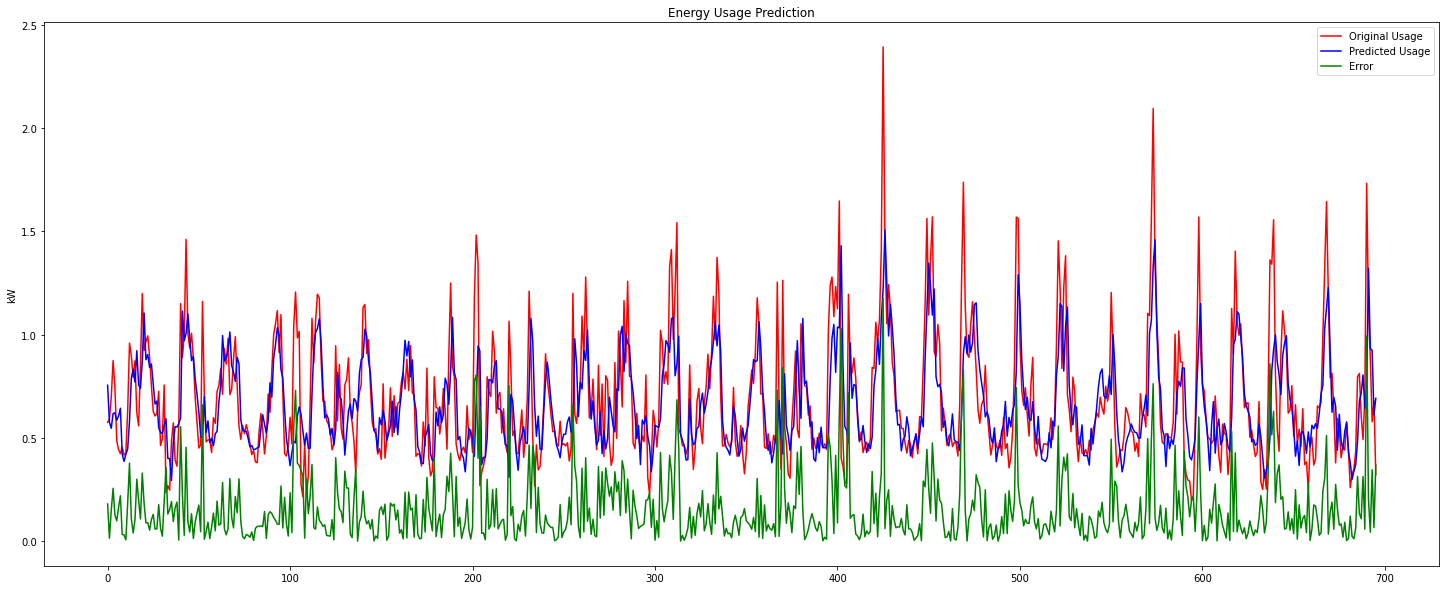

Mean Absolute Percentage Error:  0.2354337192770853
Mean Absolute Error:  0.155541519943907
Max Absolute Error:  1.1755069570219048
Mean Squared Error:  0.05086361415028422
wape:  0.2266737673626471
Testing with  MAC001251.csv


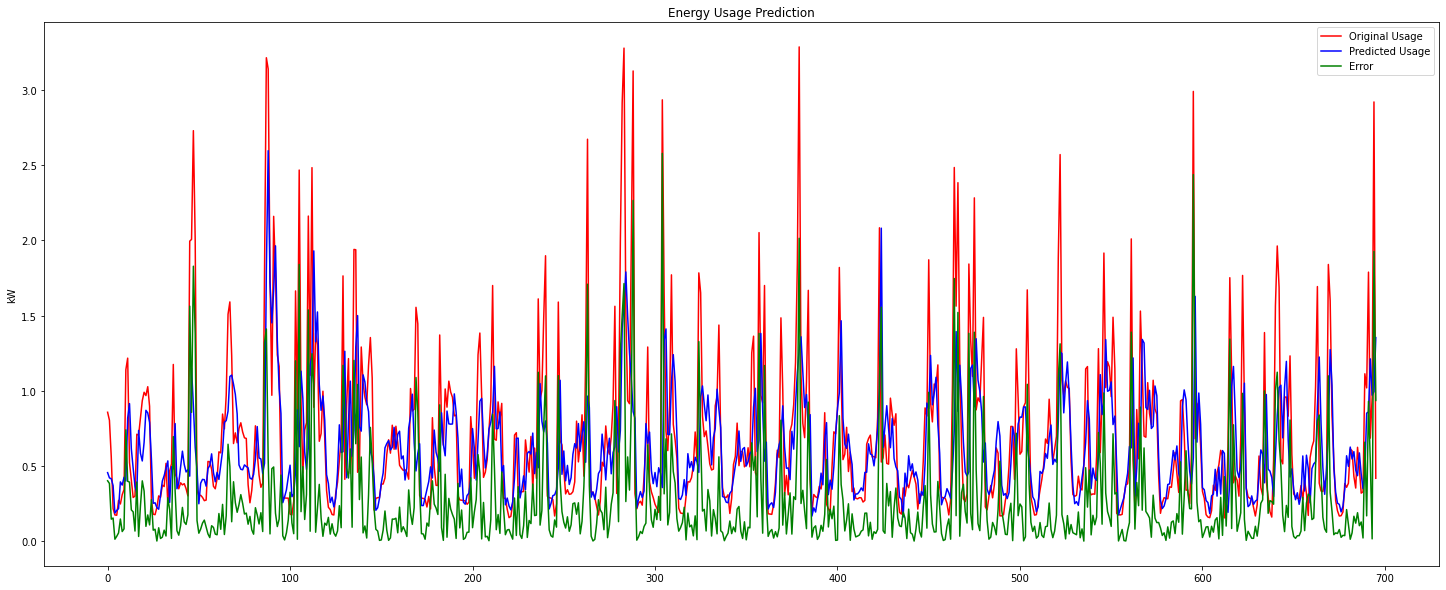

Mean Absolute Percentage Error:  0.39884975849585486
Mean Absolute Error:  0.2783129908257492
Max Absolute Error:  2.579082601565929
Mean Squared Error:  0.21482940090310665
wape:  0.39627233234286596


In [12]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')

    specific_model = SVR(kernel = "rbf")
        
    features = df[featuresNames].values
    target = df[targetName].values.reshape(-1, 1)
    
    x_train, x_test, y_train, y_test = train_test_split(features,target, test_size=24*30, shuffle=False)


    #SCALE
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)
    

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train)

    #Time series
    batch_size=1
    train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)
    svr_x_Train = [arr[0].flatten() for arr in train_generator]
    svr_y_Train = [arr[1].flatten() for arr in train_generator]
    svr_x_Test = [arr[0].flatten() for arr in test_generator]
    
    specific_model.fit(svr_x_Train, svr_y_Train)


    prediction = specific_model.predict(svr_x_Test).reshape(-1, 1)
    prediction = y_scaler.inverse_transform(prediction)
    
    prediction = [p[0] for p in prediction]
    t = [p[0] for p in y_test[past_window:]]
            
    predict_evaluate(prediction, t, showplots=True)

## Test specific model LSTM

Testing with  MAC000205.csv


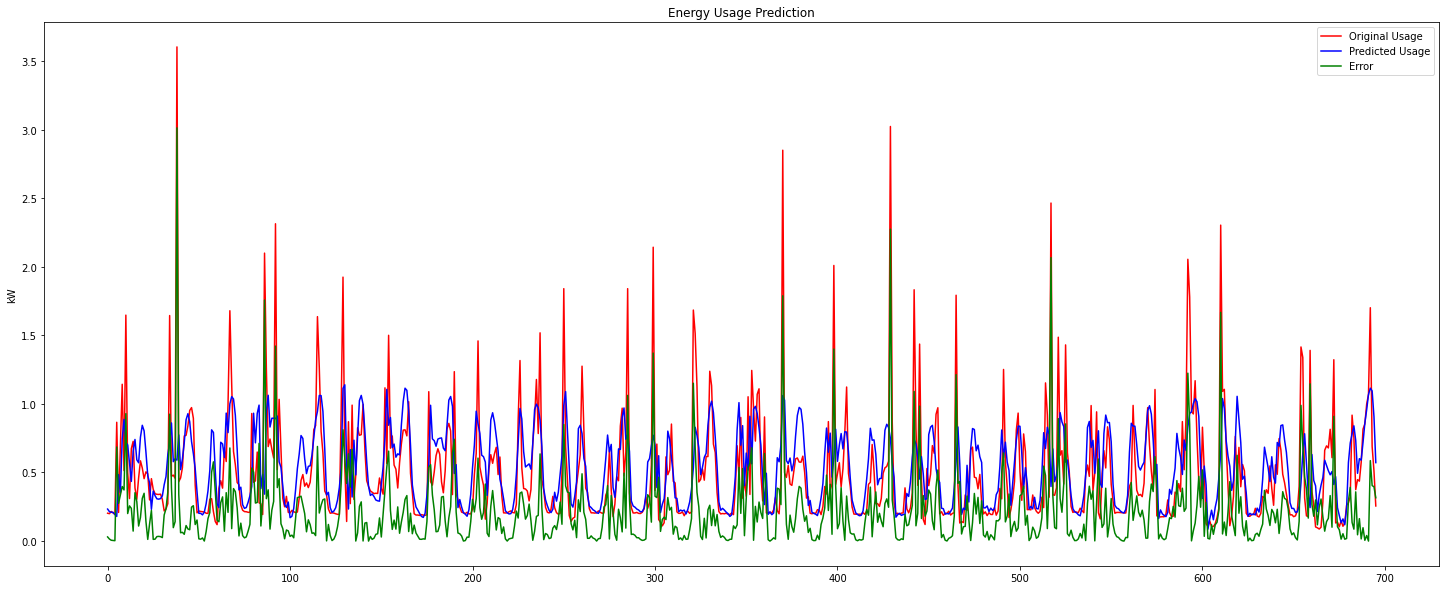

Mean Absolute Percentage Error:  0.492494976130404
Mean Absolute Error:  0.21992059619502086
Max Absolute Error:  3.0117878932952884
Mean Squared Error:  0.1274331597615643
wape:  0.4413427723972784
Testing with  MAC002086.csv


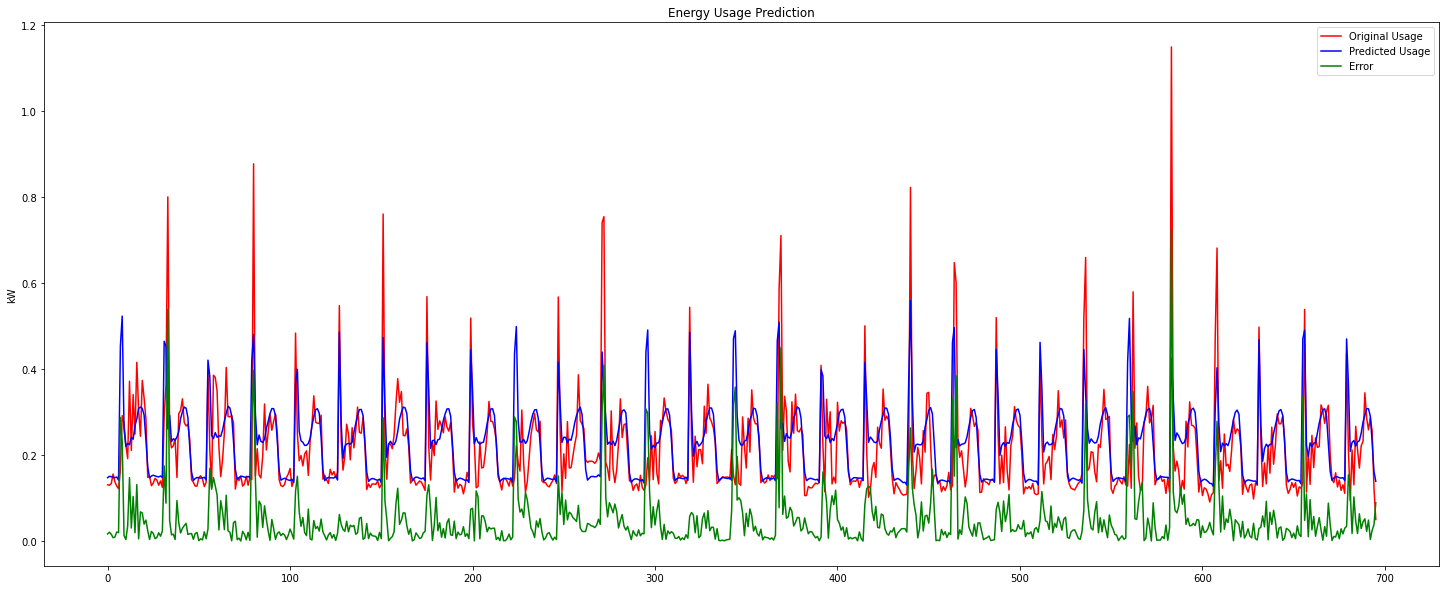

Mean Absolute Percentage Error:  0.25067435777521063
Mean Absolute Error:  0.04998080655161677
Max Absolute Error:  0.7240145444869994
Mean Squared Error:  0.00742118185817023
wape:  0.2350131155244242
Testing with  MAC000387.csv


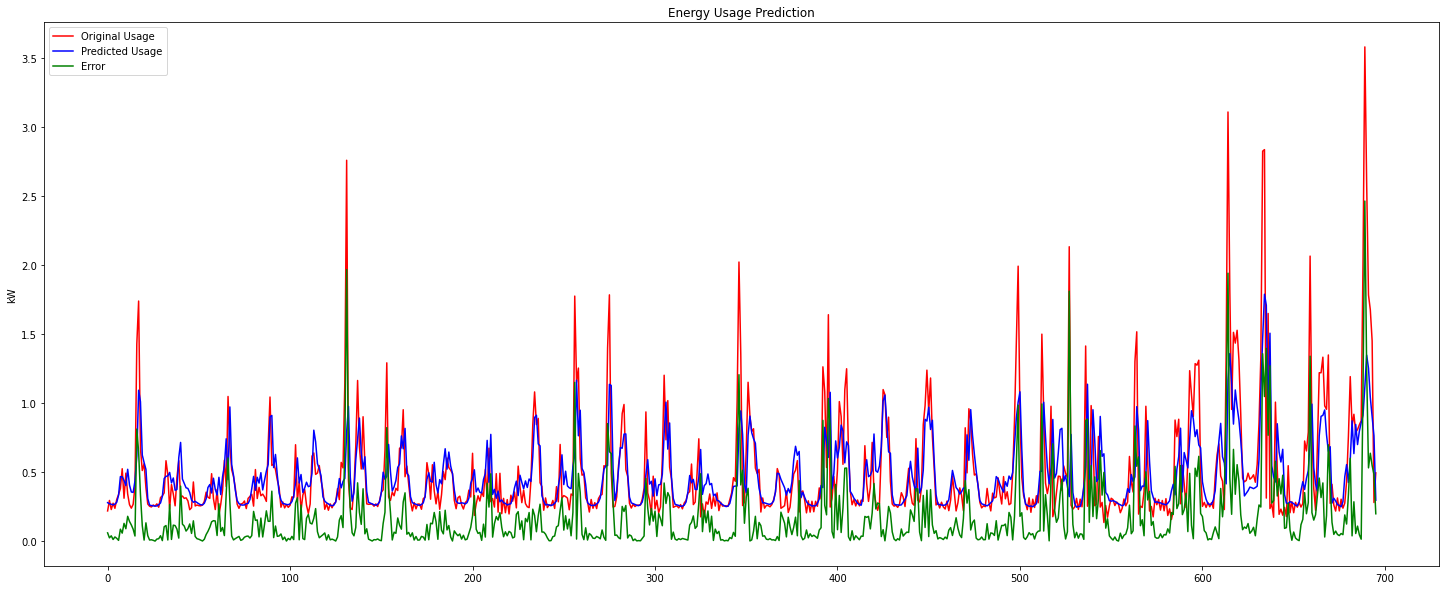

Mean Absolute Percentage Error:  0.370457369371
Mean Absolute Error:  0.1756095217100335
Max Absolute Error:  2.466162451744079
Mean Squared Error:  0.09923275698855735
wape:  0.35608519677240513
Testing with  MAC000276.csv


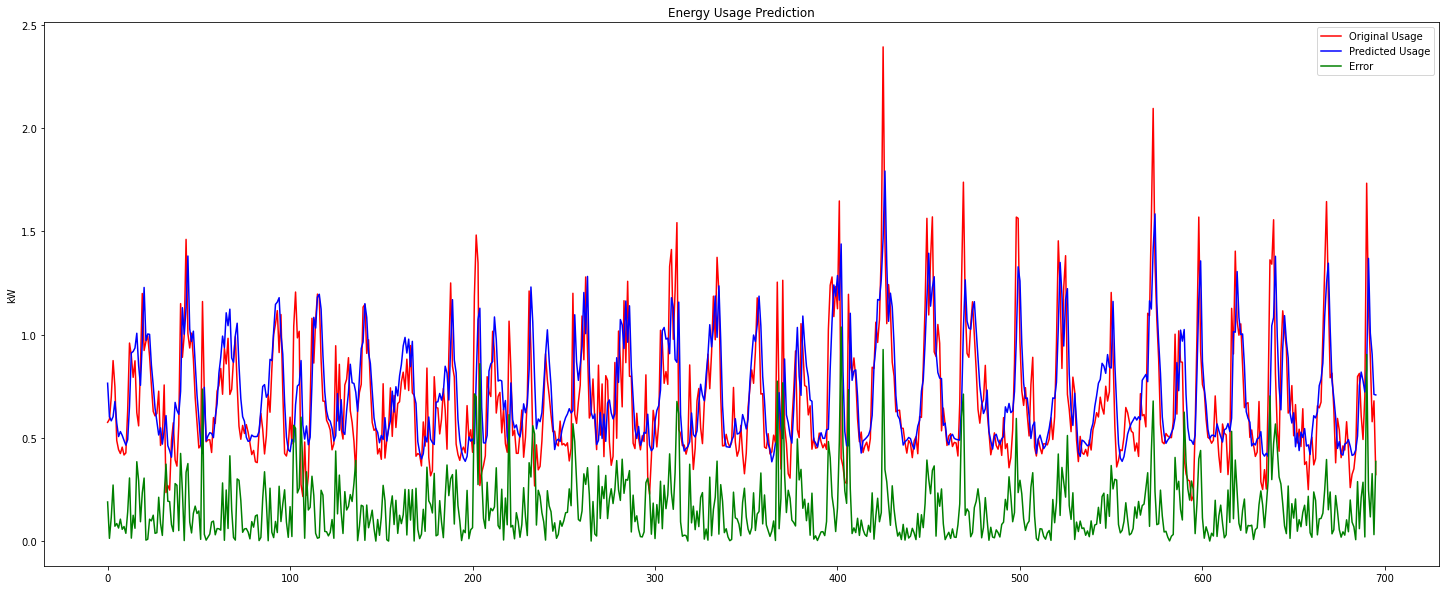

Mean Absolute Percentage Error:  0.26364856159252353
Mean Absolute Error:  0.16378255351692783
Max Absolute Error:  1.0366366605758666
Mean Squared Error:  0.05093099209018019
wape:  0.23868359038374368
Testing with  MAC001251.csv


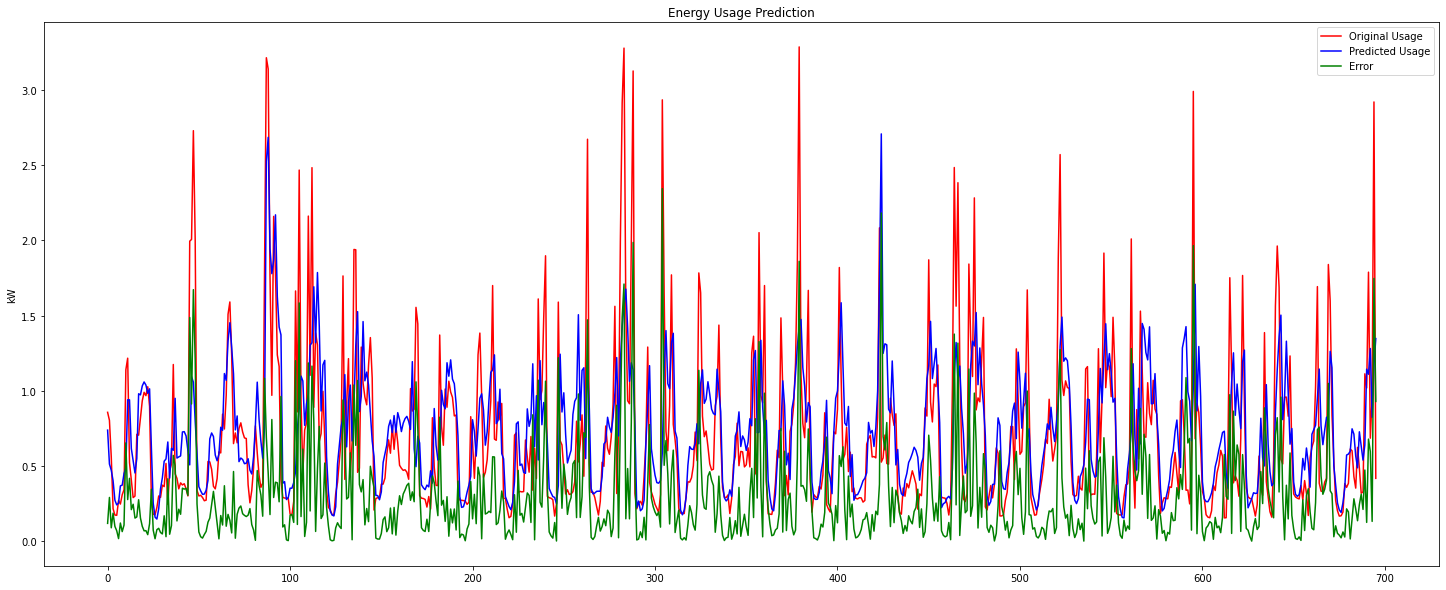

Mean Absolute Percentage Error:  0.4923433769907019
Mean Absolute Error:  0.2982818384815534
Max Absolute Error:  2.34443696035614
Mean Squared Error:  0.2011070219358352
wape:  0.42470471636952206


In [13]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')

    specific_model = define_model(past_window, len(featuresNames))
        
    features = df[featuresNames].values
    target = df[targetName].values.reshape(-1, 1)
    
    x_train, x_test, y_train, y_test = train_test_split(features,target, test_size=24*30, shuffle=False)


    #SCALE
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)
    

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train)

    #Time series
    batch_size=64
    train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)
    
    train(specific_model, train_generator)


    prediction = specific_model.predict(test_generator).reshape(-1, 1)
    prediction = y_scaler.inverse_transform(prediction)
    
    prediction = [p[0] for p in prediction]
    t = [p[0] for p in y_test[past_window:]]
    
    predict_evaluate(prediction, t, showplots=True)

# base

Testing with  MAC000205.csv


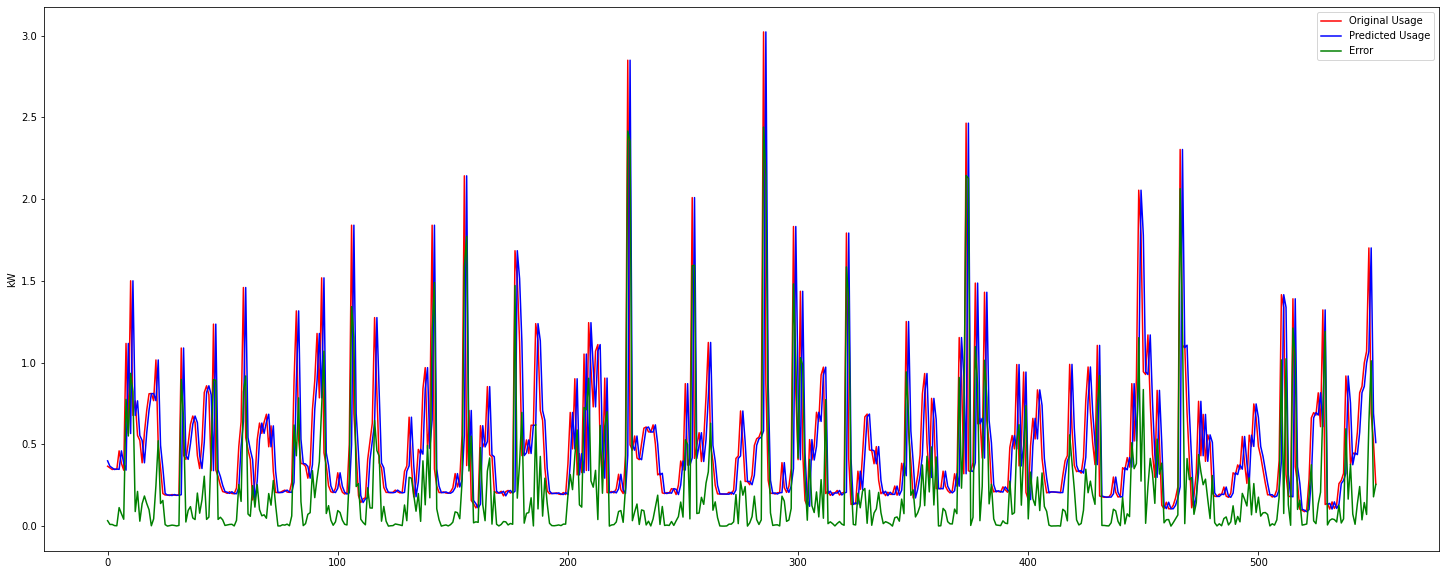

Mean Absolute Percentage Error:  0.47593009648415263
wape:  0.5022763362445907
Mean Absolute Error:  0.2424365945652174
Max Absolute Error:  2.4400001
Mean Squared Error:  0.20834610065652195
Testing with  MAC002086.csv


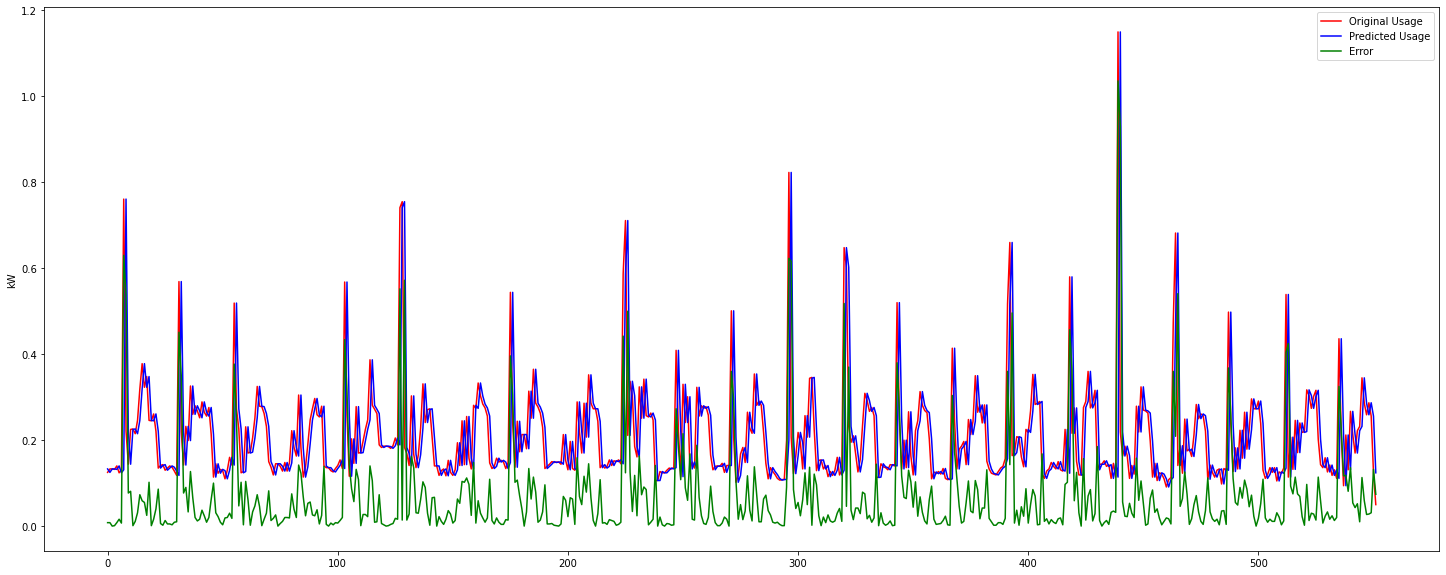

Mean Absolute Percentage Error:  0.31325585380650467
wape:  0.336889888029052
Mean Absolute Error:  0.07058514492753624
Max Absolute Error:  1.0359999999999998
Mean Squared Error:  0.018763664855072464
Testing with  MAC000387.csv


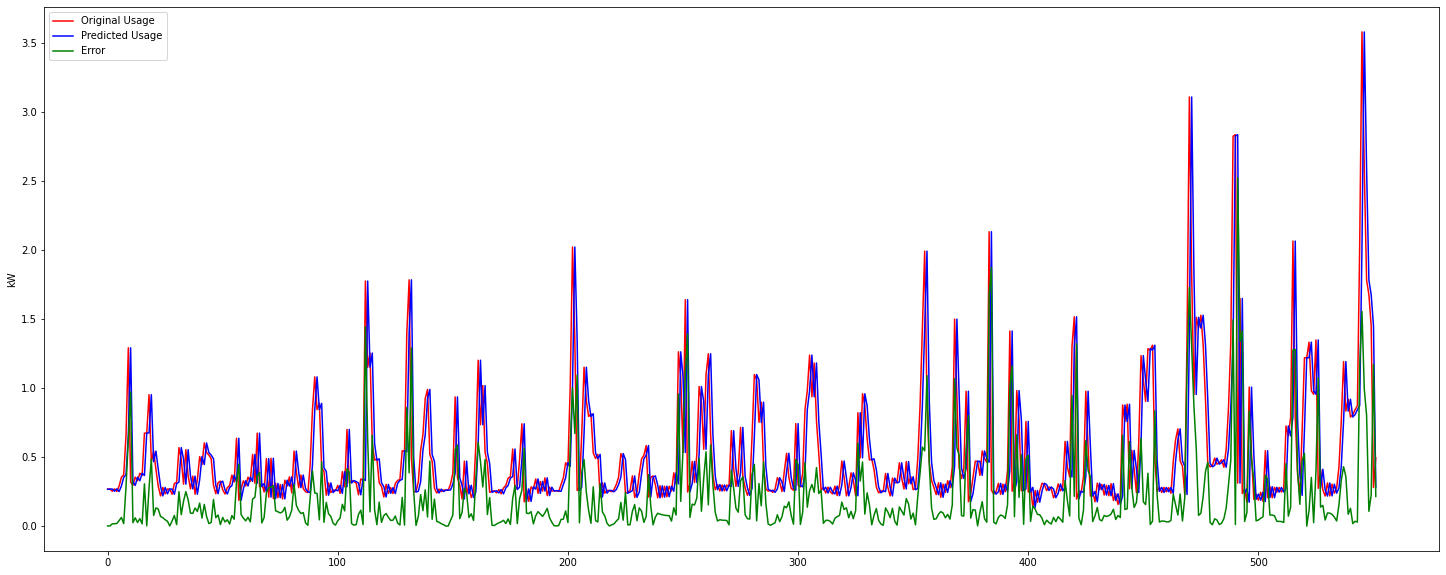

Mean Absolute Percentage Error:  0.4642389543884544
wape:  0.4283644196122099
Mean Absolute Error:  0.21972947977696633
Max Absolute Error:  2.527
Mean Squared Error:  0.14925274290914078
Testing with  MAC000276.csv


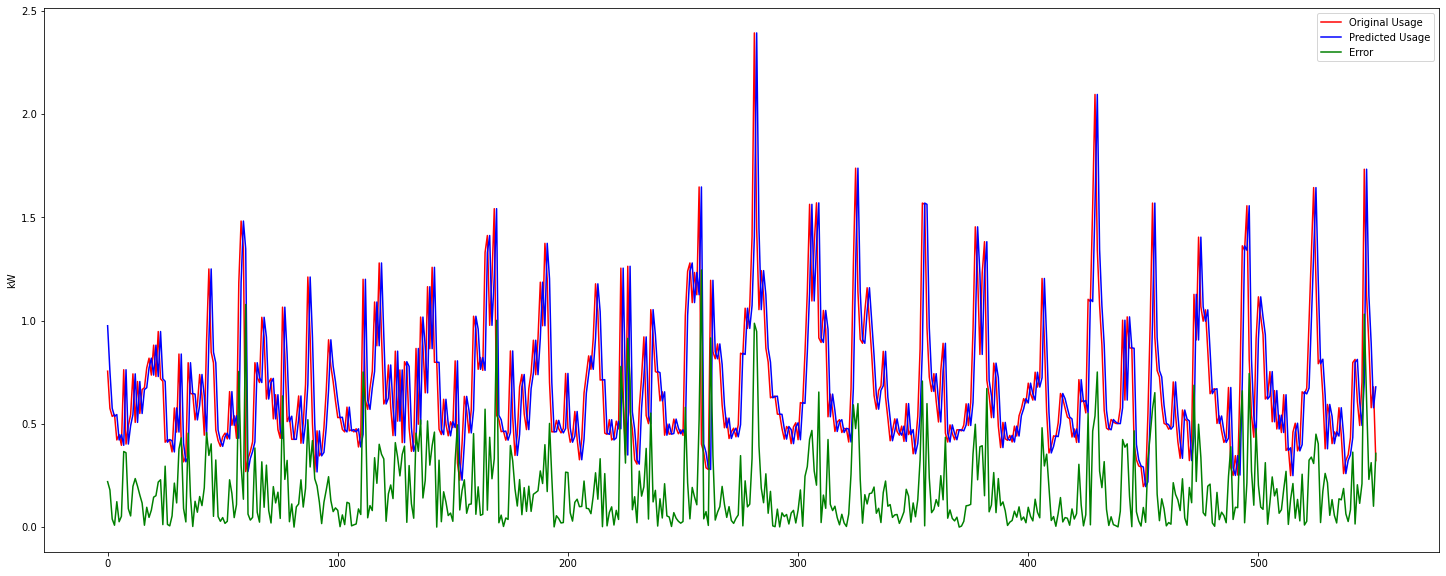

Mean Absolute Percentage Error:  0.26852384553128006
wape:  0.26865920633827806
Mean Absolute Error:  0.18379891304347828
Max Absolute Error:  1.2449999999999997
Mean Squared Error:  0.07089158876811594
Testing with  MAC001251.csv


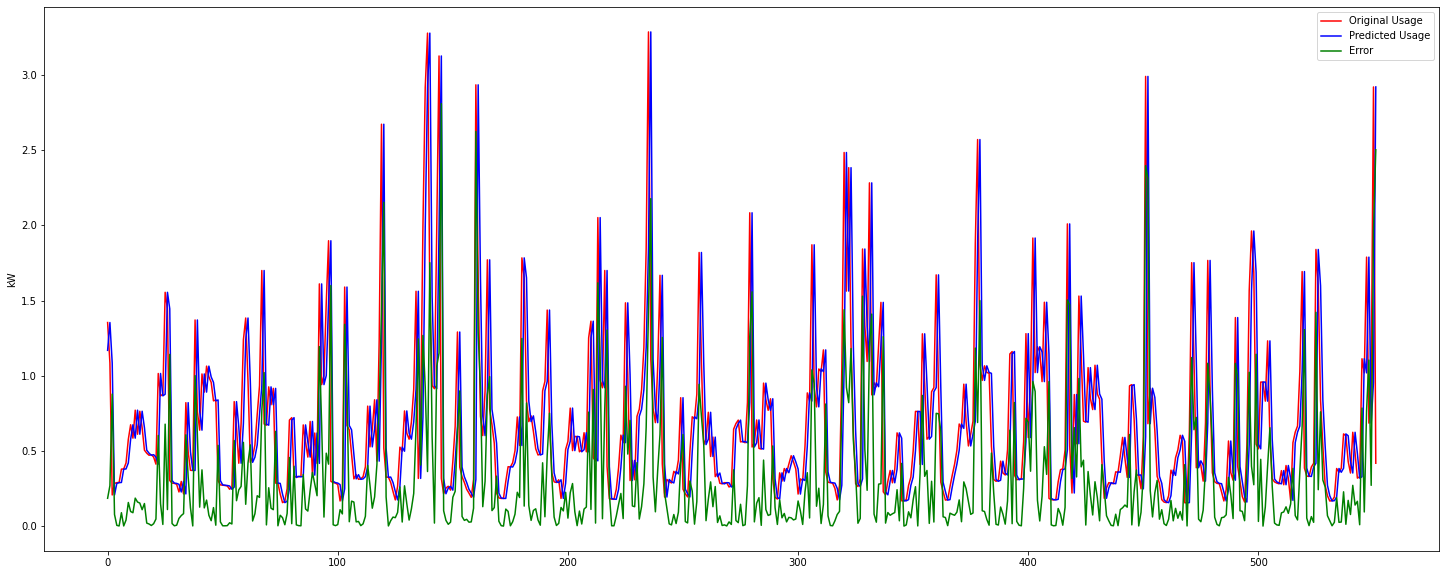

Mean Absolute Percentage Error:  0.4952468949957725
wape:  0.4691389826741862
Mean Absolute Error:  0.32001992753623193
Max Absolute Error:  2.8099999999999996
Mean Squared Error:  0.2995906892851453


In [8]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    n = 24*30
    y_test = df["use"].iloc[-n:].values
    prediction = df["use"].iloc[-n-1:][:-1].values

    equalTest = 7*24 - (24*30-len(prediction))
    prediction = prediction[equalTest:]
    y_test = y_test[equalTest:]  

    diff = [abs(prediction[i]-y_test[i]) for i in range(len(prediction))]

    resultingPlot = plt.figure(figsize=(25,10))
    plt.plot(y_test, color='red', label='Original Usage')
    plt.plot(prediction, color='blue', label='Predicted Usage')
    plt.plot(diff, color='green', label='Error')
    plt.ylabel('kW')
    plt.legend()

    mape = mean_absolute_percentage_error(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)
    maxae = max(diff)
    mse = mean_squared_error(y_test, prediction)
    df = pd.DataFrame({'Actual': y_test,
                       'Forecasted': prediction})

    wape = (df.Actual - df.Forecasted).abs().sum() / df.Actual.sum()

    plt.show()
    print("Mean Absolute Percentage Error: ", mape)
    print("wape: ", wape)
    print("Mean Absolute Error: ", mae)
    print("Max Absolute Error: ", maxae)
    print("Mean Squared Error: ", mse)

## loop, takes too much time with smv

In [ ]:
x_trainALL = []
y_trainALL = []
for filename in trainUsers:
    print("Training with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        #print(df.isna().values.any())
        #print(df[df['use'].isna()])
        #continue
        
        features = df[featuresNames].values
        target = df[targetName].values.reshape(-1,1)
        
        #SCALE
        x_scaler = StandardScaler()
        x_train = x_scaler.fit_transform(features)

        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(target)
        
        #Time series
        batch_size=1
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        svr_x_Train = [arr[0].flatten() for arr in train_generator]
        svr_y_Train = [arr[1].flatten() for arr in train_generator]
        
        x_trainALL += svr_x_Train
        y_trainALL += svr_y_Train
        

model.fit(x_trainALL, y_trainALL)
                
#prediction = model.predict(x_test).reshape(-1, 1)
#prediction = y_scaler.inverse_transform(prediction)

Training with  MAC000289.csv
Training with  MAC002565.csv
Training with  MAC002540.csv
Training with  MAC000720.csv
Training with  MAC002335.csv
Training with  MAC002285.csv
Training with  MAC000116.csv
Training with  MAC003289.csv
Training with  MAC000800.csv
Training with  MAC001445.csv


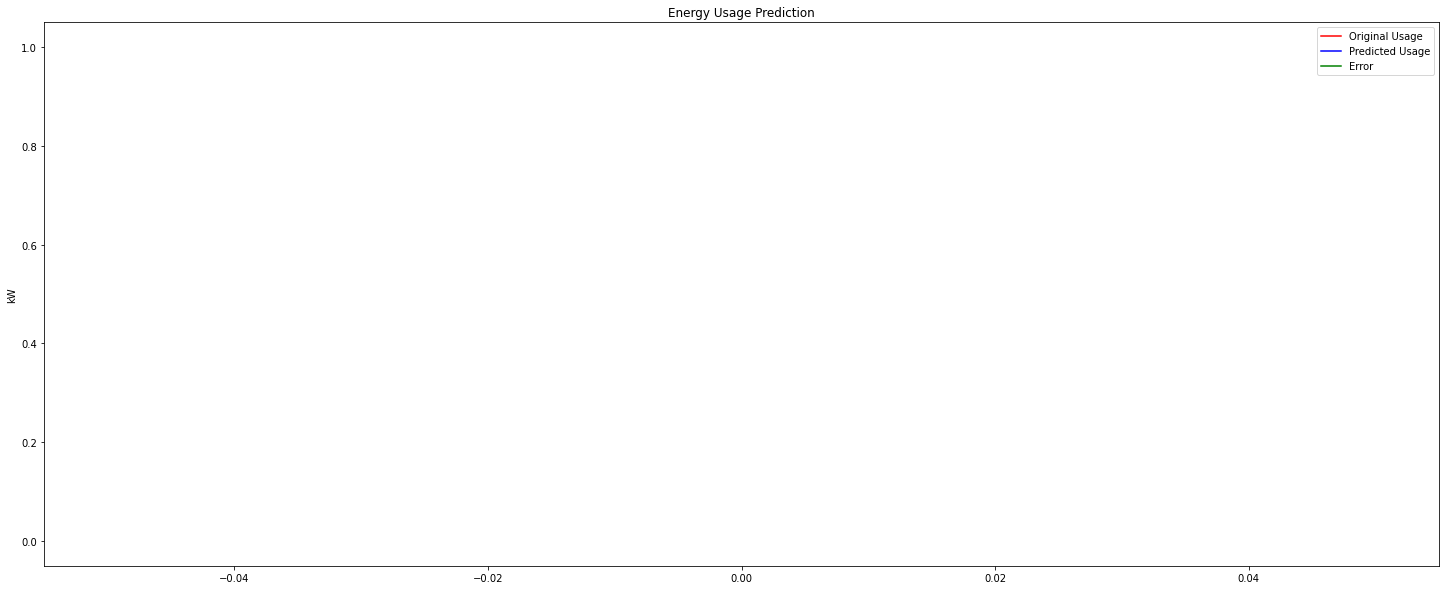

Mean Absolute Percentage Error:  4503599627370496.0
Mean Absolute Error:  1.0
Max Absolute Error:  1
Mean Squared Error:  1.0


{'name': 'Energy Usage Prediction',
 'mape': 4503599627370496.0,
 'mae': 1.0,
 'maxae': 1,
 'mse': 1.0}

In [34]:
a = [1]
b = [0]

predict_evaluate(a, b, showplots=True)